In [1]:
import pandas as pd
import seaborn as sb
from matplotlib.colors import LogNorm

from trainer import simulation_hyperparameter_reference, path_prefix

In [2]:
sb.set(rc={'figure.figsize':(20,15)}, style="darkgrid")

In [3]:
internal_columns = ["actornet", "criticnet", "state_size", "action_size"]
pd.DataFrame([{"id": id, **parms._asdict()} for (id, parms) in simulation_hyperparameter_reference.items()]).drop(internal_columns, axis=1).set_index("id")

,batch_size,gamma,lr_actor,lr_critic,memory_size,name,nonlinearity,tau,times,weight_decay
id,,,,,,,,,,
1,256,0.99,0.00010,0.00010,100000,,relu,0.001,1,0.0000
2,256,0.99,0.00010,0.00100,100000,,relu,0.001,1,0.0000
10,128,0.99,0.00010,0.00010,100000,,relu,0.001,1,0.0000
11,1024,0.99,0.00010,0.00010,100000,,relu,0.001,1,0.0000
12,4096,0.99,0.00010,0.00010,100000,,relu,0.001,1,0.0000
13,512,0.99,0.00010,0.00010,100000,,relu,0.001,1,0.0000
14,384,0.99,0.00010,0.00010,100000,,relu,0.001,1,0.0000
20,256,0.99,0.00010,0.00020,100000,,relu,0.001,1,0.0000
21,256,0.99,0.00010,0.00040,100000,,relu,0.001,1,0.0000


In [4]:
param_reference = dict([(id, {"id": id, **parms._asdict()}) for (id, parms) in simulation_hyperparameter_reference.items()])
experiments = {
    "Batch size change": ([param_reference[x] for x in [1,10,11,12,13,14]], "batch_size"),
    "Critic learning rate change": ([param_reference[x] for x in [1,20,21,22,23,24,25]], "lr_critic"),
    "Actor learning rate change": ([param_reference[x] for x in [1,30,31,32,33,34]], "lr_actor"),
    "Learning rate change": ([param_reference[x] for x in [1,2,35,36]], ["lr_actor", "lr_critic"]),
    "Weight decay change": ([param_reference[x] for x in [1,40,41,42]], "weight_decay"),
}

In [5]:
experiment_outcomes = []
for experiment in experiments:
    (experiment_hparm, var_under_test) = experiments[experiment]
    experiment_data = [[par, pd.read_json(f"{path_prefix}set{par['id']}_results.json")] for par in experiment_hparm]
    
    for exp_item in experiment_data:
        df = exp_item[1].T
        df["episode"] = df.index
        df = df.melt(id_vars = ["episode"], var_name="run_id", value_name="score")
        df["run_id"] = df["run_id"].astype(str).astype("int64")
        var_under_test_label = var_under_test if isinstance(var_under_test, str) else " ".join(var_under_test)
        if isinstance(var_under_test, list):
            df[var_under_test_label] = " ".join([str(exp_item[0][vut]) for vut in var_under_test])
        else:
            df[var_under_test_label] = exp_item[0][var_under_test]
            
        ma_score = df.groupby('run_id')['score'].rolling(window = 100).mean().reset_index().fillna(0)
        df["ma_score"] = ma_score["score"]
        exp_item[1] = df

    experiment_df = pd.concat([x[1] for x in experiment_data])
    experiment_outcomes.append((experiment, experiment_df, var_under_test_label))

In [6]:
def render_experiment_results(results):
    plt = sb.lineplot(
        data = results[1], 
        x = 'episode', 
        y = 'ma_score', 
        hue = results[2], 
        legend = "full",
        hue_norm = LogNorm(), 
        palette = "Paired"
    )
    plt.set_title(results[0])

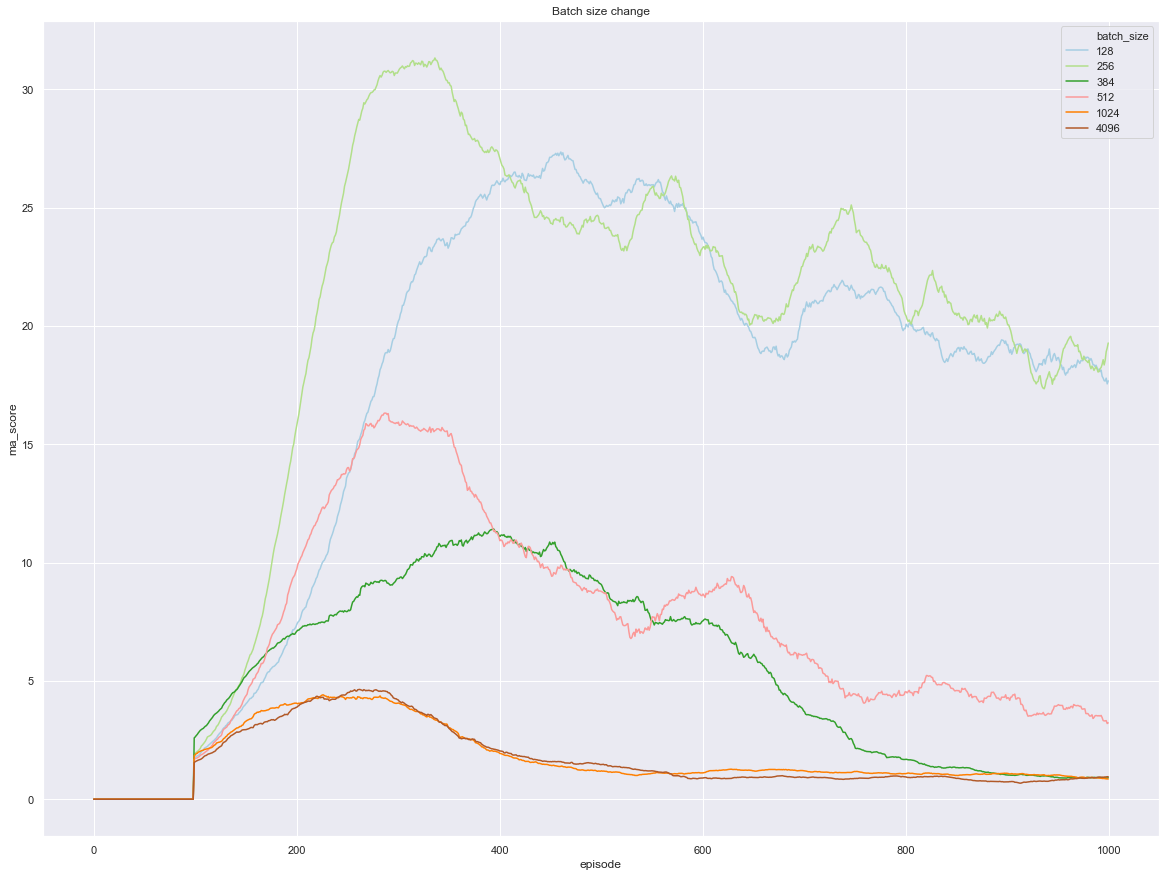

In [7]:
render_experiment_results(experiment_outcomes[0])

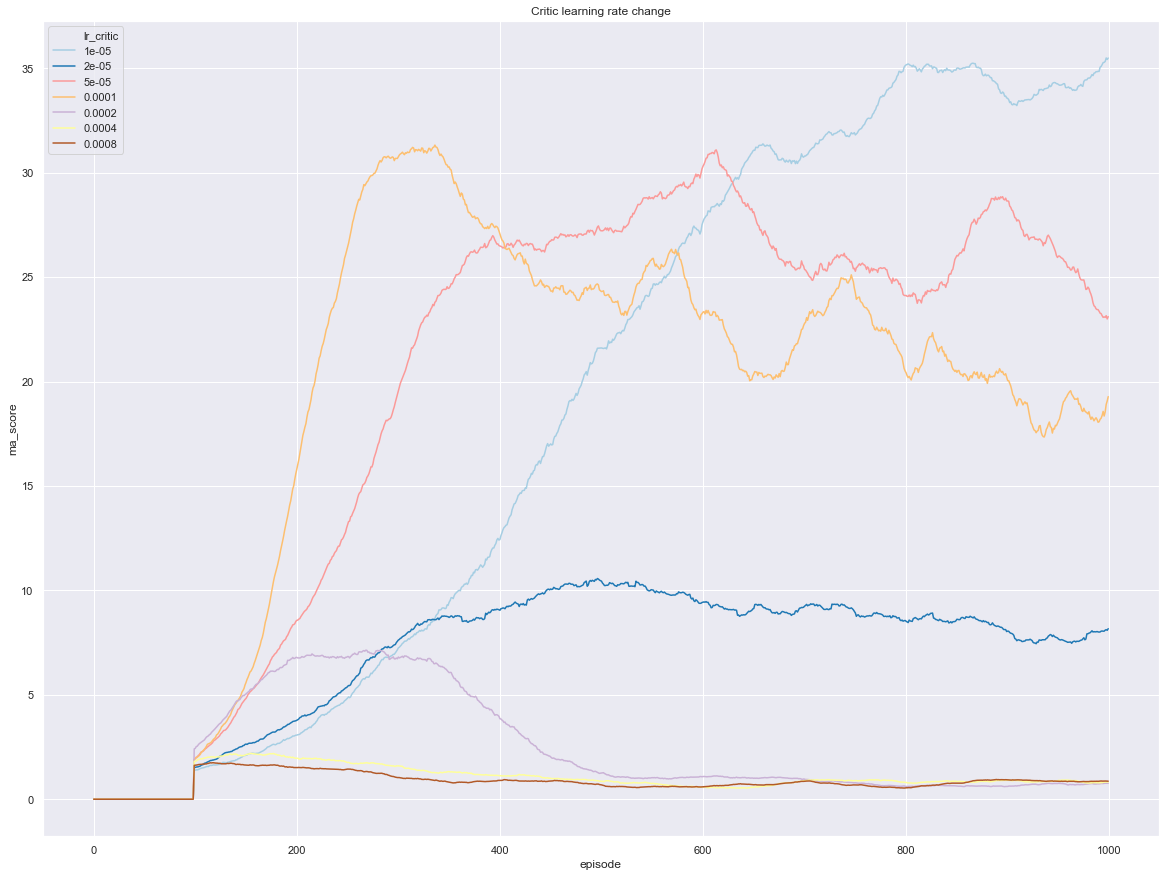

In [8]:
render_experiment_results(experiment_outcomes[1])

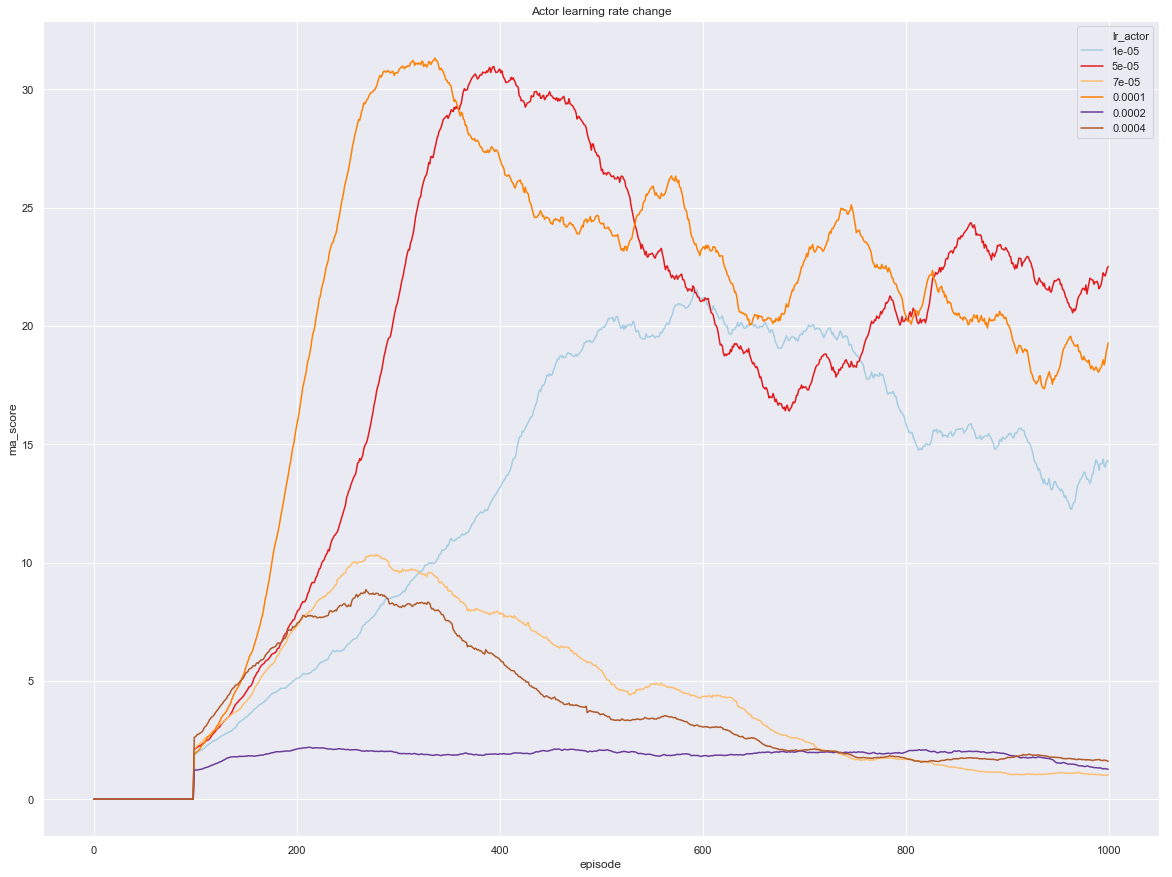

In [9]:
render_experiment_results(experiment_outcomes[2])

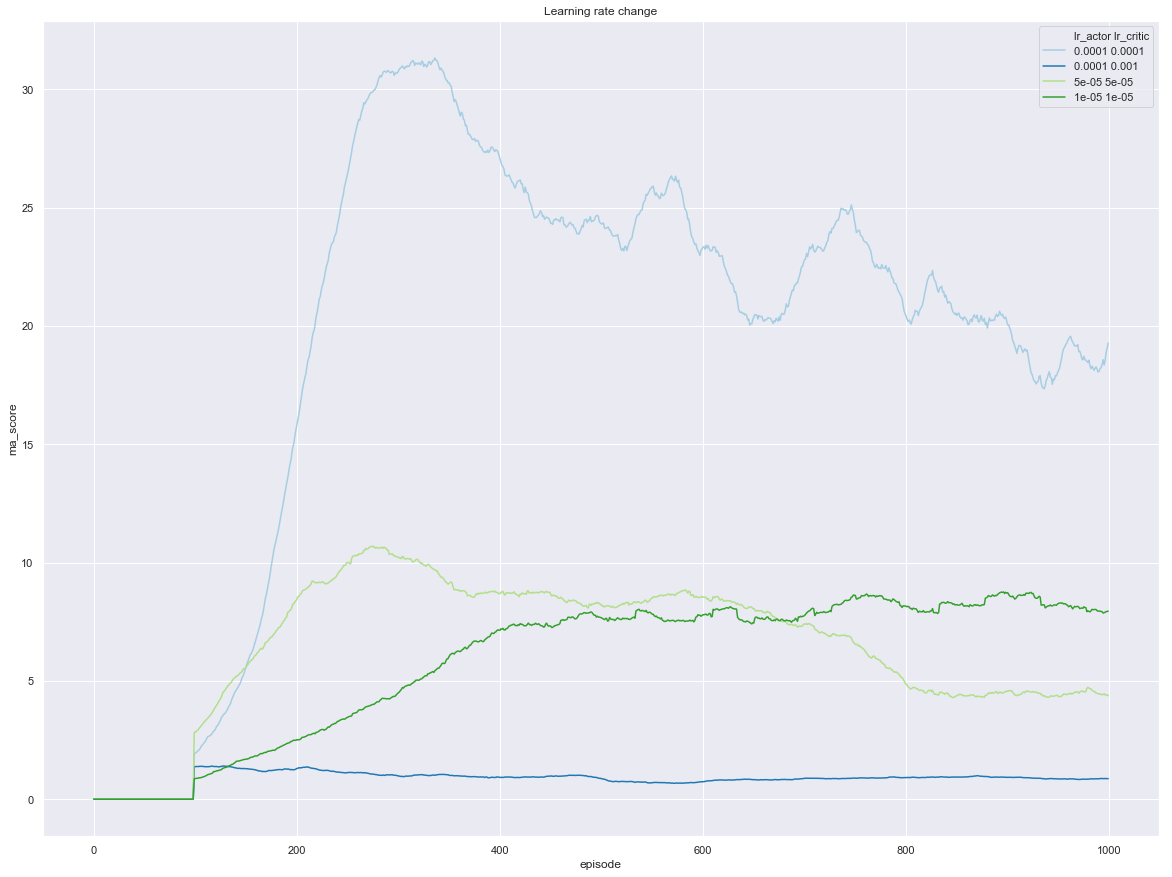

In [10]:
render_experiment_results(experiment_outcomes[3])

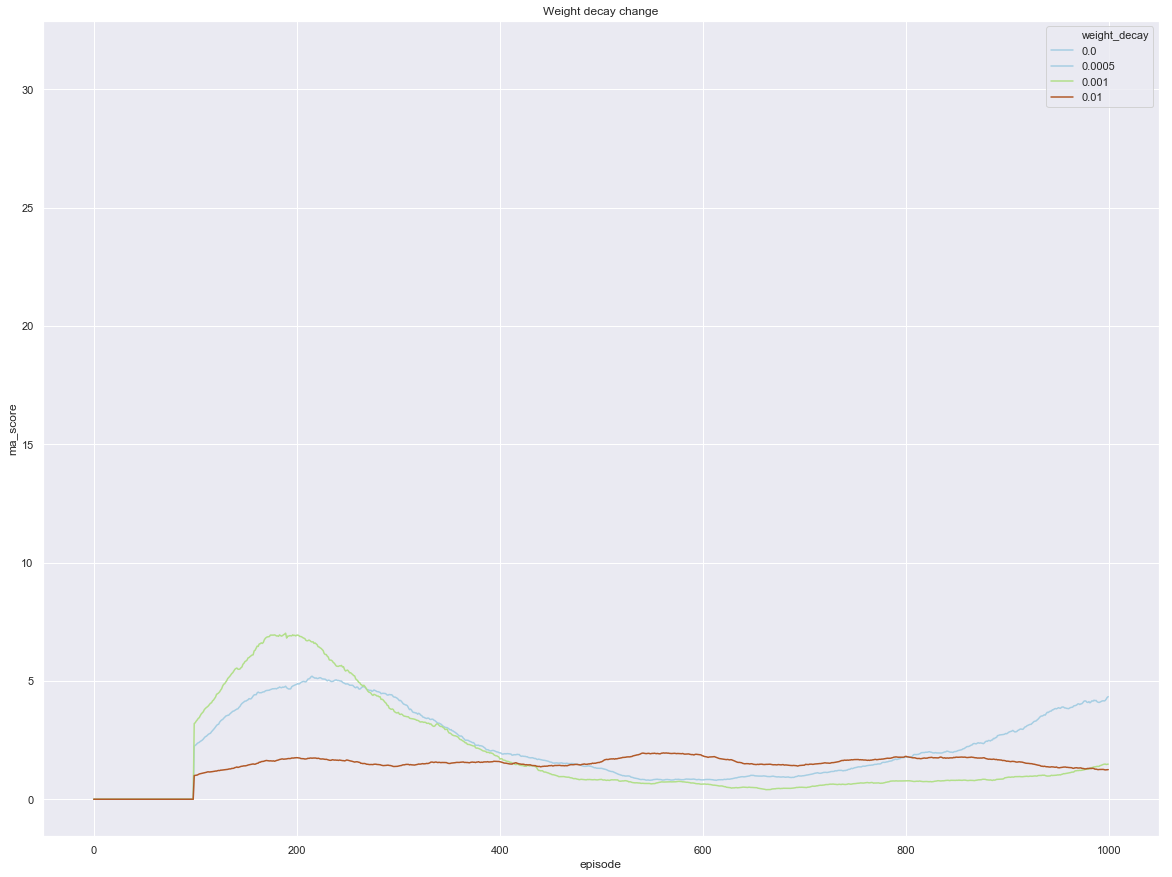

In [11]:
render_experiment_results(experiment_outcomes[4])